In [89]:
import numpy as np
import seaborn as sns
import pandas as pd
import sys
import math
import matplotlib.pyplot as plt
import random
np.set_printoptions(threshold=sys.maxsize)

### Model 1

In [90]:
north_south_block = 264 #feet of north-south block
east_west_block = 750 # feet of east-west block
streets_A = 145 #number of streets in the Grid Parition A for Model 1 (1st - 145th)
streets_B = 83 #number of streets in the Grid Parition B for Model 1 (146th - 228th)
total_streets = streets_A + streets_B
total_avenues = 11
total_speed = 3 * 26400 #speed of drone in feet/hr (5 mph or 10 blocks an hr)
time_step = 0.6 #number of minutes the simulation runs everytime (drone moves 1 block per simulation) 
#time_step = (north_south_block)/(total_speed/60) --> formula for it, should we wish to change speed

In [91]:
#class representing a grid block
class gridBlock():
    def __init__(self, timestep = time_step, less=15):
        self.used = True 
        self.last_visited = -1
        self.num_visits = 0
        self.less15 = 0
        self.value = less
        self.timestep = timestep
        
    def last_visit(self, time):
        return self.last_visited
    
    def visit(self, time):
        if(time - self.last_visited > self.less/self.timestep):
            self.less15 = self.less15 + 1 
        self.last_visited = time
        self.num_visits = self.num_visits + 1
        
        

In [92]:
class Drone():
    def __init__(self, column_start, column_dest, first_row,row_start, row_end, orientation, speed = total_speed, timesteps = time_step, timeout=1):
        self.speed = speed
        self.curr_col = column_start
        if first_row > row_end: 
            self.curr_row = row_end
        else:
            self.curr_row = first_row
        self.col_range = (column_start, column_dest) #total range of columns (only two avenues)
        self.row_range = [row_start, row_end] # total range of rows
        self.timesteps = timesteps
        self.charge = 300/timesteps #time left in the drone in timesteps (using defaults is 500)
        self.col_change = -1 #NOTE: it takes 3 time steps to move from east to west + 1 recharge penalty
        self.orientation = orientation #-1 for south-north, 1 for north-south
        self.timeout = timeout #2 hours to charge
        
    #moves drone and returns coordinates and whether it is monitoring
    def move(self, manhattan = []):
        #checking if drone is timed out
        if(self.timeout > 0):
            if self.charge > 0 :
                #reached end of the block, time to move
                if((self.curr_row == self.row_range[-1] and self.orientation == 1) or (self.curr_row == self.row_range[0] and self.orientation == -1)):
                   #row does not change
                    self.orientation = self.orientation * -1 #becomes opposite direction of change

                    index = 0 if self.col_range.index(self.curr_col) == 1 else 0 #changes to the next column
                    self.curr_col = self.col_range[index]

                    self.col_change = 3 #takes 3 steps to move a column
                    self.charge = self.charge - 4 #3 time steps before drone is back + 1 time step penalty
                else:
                    #still in the process of moving the columns (it takes longer to move from avenue to avenue)
                    if(self.col_change > 0):
                        self.col_change = self.col_change - 1
                    #normal move    
                    else:
                        self.curr_row = self.curr_row + self.orientation
                        self.charge = self.charge - 1
                return True
            else:
                self.timeout = -120/self.timesteps
                self.charge = 300/self.timesteps
            return False
#             return (self.curr_row, self.curr_col, True)
        else:
            self.timeout = self.timeout + 1            
            return False
#           return (self.curr_row, self.curr_col, False)
        
    def coord(self):
        return (self.curr_row, self.curr_col)

In [107]:
#creating grid blocks for manhattan
manhattan = np.empty((total_streets,11), dtype=object)  
manhattan2 = np.empty((total_streets,11), dtype=object)  
manhattan_rand = np.empty((total_streets,11), dtype=object)  
manhattan_rand2 = np.empty((total_streets,11), dtype=object)  
for i in range(228):
    for j in range(11):
        manhattan[i][j] = gridBlock(time_step)
        manhattan2[i][j] = gridBlock(time_step)
        manhattan_rand[i][j] = gridBlock(time_step)
        manhattan_rand2[i][j] = gridBlock(time_step)
        
#setting the non-used parts of grid to False
for i in range(146, 228):
    for j in range(3, 11):
        manhattan[i][j].used = False
        manhattan2[i][j].used = False
        manhattan_rand[i][j].used = False
        manhattan_rand2[i][j].used = False

In [94]:
drone_distance = total_speed/6
drone_distance_blocks = math.ceil(drone_distance/north_south_block) #number of north-south blocks between each drone
drone_distance_blocks = 1

In [95]:
drone_list = []
#makes the drones
for i in range(11):
        if(i % 2 == 0): #drone move south-north
            if(i < 8):
                for j in range(0, math.floor(streets_A/drone_distance_blocks)):
                    drone_list.append(Drone(i, i + 1, drone_distance_blocks * j + random.randrange(0, 8), 0, streets_A-1, 1, timeout=random.randrange(-120/time_step, 30)))
        #drone moves north-south
        else:
            if(i < 8):
                for j in range(0, math.floor(streets_A/drone_distance_blocks)):
                    drone_list.append(Drone(i, i - 1, drone_distance_blocks * j + random.randrange(0, 8), 0, streets_A-1, -1, timeout=random.randrange(-120/time_step, 30)))
        #triple circulation for the longer part of the island (block B)            
        for j in range(0, math.floor(total_streets/drone_distance_blocks)):
            if(i == 8):
                drone_list.append(Drone(i, i + 1, drone_distance_blocks * j + random.randrange(0, 8), 0, total_streets-1, 1, timeout=random.randrange(-120/time_step, 30)))
            if(i == 9):    
                drone_list.append(Drone(i, i - 1, drone_distance_blocks * j + random.randrange(0, 8), 0, total_streets-1, -1, timeout=random.randrange(-120/time_step, 30)))
            if(i == 10):    
                drone_list.append(Drone(i, i + 1, drone_distance_blocks * j + random.randrange(0, 8), 0, total_streets-1, 1, timeout=random.randrange(-120/time_step, 30)))         

In [96]:
simulations = 10
prt1 = np.zeros(manhattan.shape)
prt2 = np.zeros(manhattan.shape)
for i in range(simulations):
    simulation_days = 5
    simulation_timesteps = math.ceil(simulation_days*24*60 / time_step)
    for t in range(simulation_timesteps):
        for drone in drone_list:
            val = drone.move(manhattan)
            if(val):
                row, col = drone.coord()
                manhattan[row][col].visit(t)
    for i in range(228):
        for j in range(11):
            prt1[i][j] = manhattan[i][j].num_visits + prt1[i][j]
            prt2[i][j] = manhattan[i][j].less15 + prt2[i][j]
prt1 = (1/simulations) * prt1        
prt2 = (1/simulations) * prt2

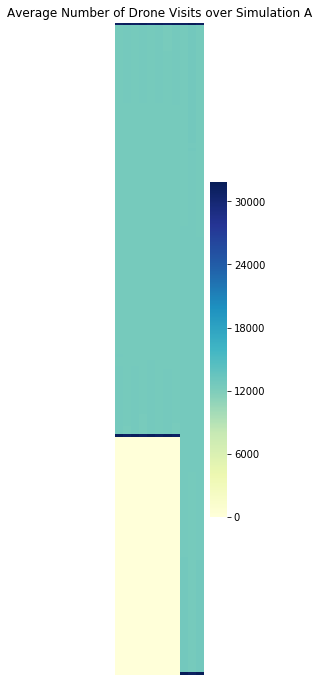

In [97]:
# plt.figure(figsize=(10, 60)) high res image
plt.figure(figsize=(2, 12))
plt.title("Average Number of Drone Visits over Simulation A")
heat_map = sns.heatmap(prt1, xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.show()

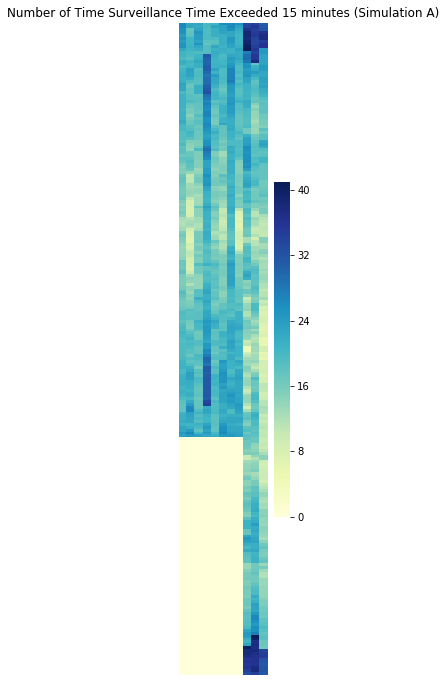

In [98]:
# plt.figure(figsize=(10, 60)) high res image
plt.figure(figsize=(2, 12))
plt.title("Number of Time Surveillance Time Exceeded 15 minutes (Simulation A)")
heat_map = sns.heatmap(prt2, xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.show()

#### Random Drones not working

In [99]:
drone_list_rand = []
prob = 0.15
#makes the drones
for i in range(11):
        if(i % 2 == 0): #drone move south-north
            if(i < 8):
                for j in range(0, math.floor(streets_A/drone_distance_blocks)):
                    if random.uniform(0, 1) > prob:
                        drone_list.append(Drone(i, i + 1, drone_distance_blocks * j + random.randrange(0, 8), 0, streets_A-1, 1, timeout=random.randrange(-120/time_step, 30)))
        #drone moves north-south
        else:
            if(i < 8):
                for j in range(0, math.floor(streets_A/drone_distance_blocks)):
                    if random.uniform(0, 1) < prob:
                        drone_list.append(Drone(i, i - 1, drone_distance_blocks * j + random.randrange(0, 8), 0, streets_A-1, -1))
        #triple circulation for the longer part of the island (block B)            
        for j in range(0, math.floor(total_streets/drone_distance_blocks)):
            if(i == 8):
                if random.uniform(0, 1) < prob:
                    drone_list.append(Drone(i, i + 1, drone_distance_blocks * j + random.randrange(0, 8), 0, total_streets-1, 1))
            if(i == 9):
                if random.uniform(0, 1) < prob:
                    drone_list.append(Drone(i, i - 1, drone_distance_blocks * j + random.randrange(0, 8), 0, total_streets-1, -1))
            if(i == 10):    
                if random.uniform(0, 1) < prob:
                    drone_list.append(Drone(i, i + 1, drone_distance_blocks * j + random.randrange(0, 8), 0, total_streets-1, 1))         

In [104]:
simulations = 10
prt3 = np.zeros(manhattan_rand.shape)
prt4 = np.zeros(manhattan_rand.shape)
for i in range(simulations):
    simulation_days = 5
    simulation_timesteps = math.ceil(simulation_days*24*60 / time_step)
    for t in range(simulation_timesteps):
        for drone in drone_list:
            val = drone.move(manhattan_rand)
            if(val):
                row, col = drone.coord()
                manhattan_rand[row][col].visit(t)
    for i in range(228):
        for j in range(11):
            prt3[i][j] = manhattan_rand[i][j].num_visits + prt4[i][j]
            prt4[i][j] = manhattan_rand[i][j].less15 + prt3[i][j]
prt3 = (1/simulations) * prt3
prt4 = (1/simulations) * prt4

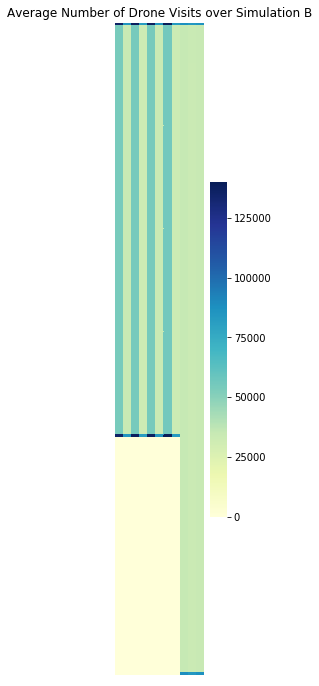

In [105]:
# plt.figure(figsize=(10, 60)) high res image
plt.figure(figsize=(2, 12))
plt.title("Average Number of Drone Visits over Simulation B")
heat_map = sns.heatmap(prt3, xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.show()

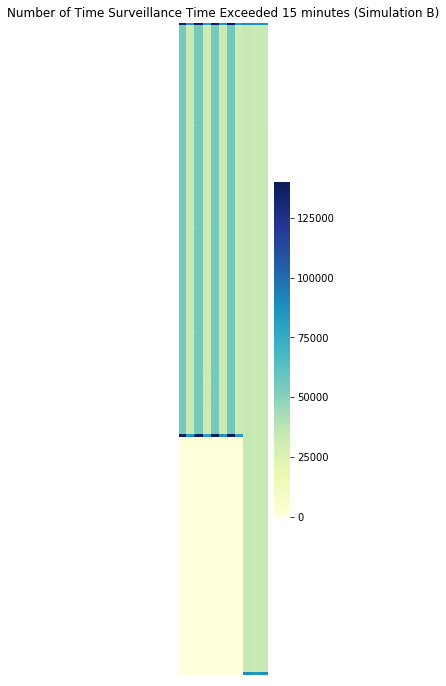

In [106]:
# plt.figure(figsize=(10, 60)) high res image
plt.figure(figsize=(2, 12))
plt.title("Number of Time Surveillance Time Exceeded 15 minutes (Simulation B)")
heat_map = sns.heatmap(prt4, xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.show()

### Model 2

In [ ]:
# each of this represents a block with boundary from bottom right corner to top left, along with monitoring frequency

block1= (84, 1, 128, 4, 5)
block2= (56, 1, 84, 4, 7)
block3= (44, 1, 56, 4, 5)
block4= (23, 1, 44, 4, 7)
block5= (95, 4, 128, 5, 5)
block6= (56, 4, 95, 5, 5)
block7= (109, 5, 128, 8, 9) #nn
block8= (59, 5, 109, 8, 20)#central park
block9= (30, 4, 56, 8, 17)
block10= (23, 4, 30, 11, 13)
block12= (95, 8, 128, 11, 11)
block13= (72, 8, 95, 11, 7)
block14= (53, 8, 72, 11, 11)
block15= (44, 8, 53, 11, 7)
block15= (30, 8, 44, 11, 9)


block_list = [
    block1,
    block2,
    block3,
    block4,
    block5,
    block6,
    block7,
    block8,
    block9,
    block10,
    block11,
    block12,
    block13,
    block14,
    block15,
    
]



In [ ]:
drone_list2 = []


In [ ]:
drone_list = []
#makes the drones
for i in range(11):
        if(i % 2 == 0): #drone move south-north
            if(i < 8):
                for j in range(0, math.floor(streets_A/drone_distance_blocks)):
                    drone_list.append(Drone(i, i + 1, drone_distance_blocks * j + random.randrange(0, 8), 0, streets_A-1, 1, timeout=random.randrange(-120/time_step, 30)))
        #drone moves north-south
        else:
            if(i < 8):
                for j in range(0, math.floor(streets_A/drone_distance_blocks)):
                    drone_list.append(Drone(i, i - 1, drone_distance_blocks * j + random.randrange(0, 8), 0, streets_A-1, -1, timeout=random.randrange(-120/time_step, 30)))
        #triple circulation for the longer part of the island (block B)            
        for j in range(0, math.floor(total_streets/drone_distance_blocks)):
            if(i == 8):
                drone_list.append(Drone(i, i + 1, drone_distance_blocks * j + random.randrange(0, 8), 0, total_streets-1, 1, timeout=random.randrange(-120/time_step, 30)))
            if(i == 9):    
                drone_list.append(Drone(i, i - 1, drone_distance_blocks * j + random.randrange(0, 8), 0, total_streets-1, -1, timeout=random.randrange(-120/time_step, 30)))
            if(i == 10):    
                drone_list.append(Drone(i, i + 1, drone_distance_blocks * j + random.randrange(0, 8), 0, total_streets-1, 1, timeout=random.randrange(-120/time_step, 30)))         

In [ ]:
drone_distance = total_speed/6
drone_distance_blocks = math.ceil(drone_distance/north_south_block) #number of north-south blocks between each drone
drone_distance_blocks = 1        